# Children's Height 

The purpose of this notebook is to explore the relationship between the heights of adult children and the heights of their parents.  
The table below gives data based on the famous 1885 study of Francis Galton exploring this relationship. Each case is an adult child, and the variables are

- Family: The family that the child belongs to, labeled from 1 to 205.
- Father: The father's height, in inches
- Mother: The mother's height, in inches
- Gender: The gender of the child, male (M) or female (F)
- Height: The height of the child, in inches
- Kids: The number of kids in the family of the child 

The data set has 898 cases. The family that we have labeled 205 was originally labeled 136A by Galton.  
https://www.randomservices.org/random/data/Galton.html#

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova, diagnostic

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
pio.templates.default = 'seaborn'
pio.renderers.default='iframe'

In [3]:
path = '~/workspace/RegressionTests/lib/data/children_heights/Galtons Height Data.csv'

data = pd.read_csv(path)
data.head(3)

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4


## 1. Scatter plot
Let's start by scatter plotting the dependent variable $y$ and independent variables $x_i \in (Family, Father, Mother, Gender, Kids)$.  
Look for:  
- What is the distribution of each?
- Do they look correlated?
- Formulate the mathmatical formula in your head
- What do you expect the signs of the coefficients to be

In [4]:
fig = px.scatter_matrix(data, color='Gender', width=900,height=1000,
                    title='Galtons Height Data from the 1800s',
                    color_continuous_scale='turbid',
                    hover_name='Family',
                    template='plotly')
fig.show()

In [5]:
#Correlation matrix

# sns.heatmap(data.corr(),vmin=-1,vmax=1, annot=True,cmap='ocean');
fig3 = px.imshow(data.corr(), zmin=-1, zmax=1,width=500,height=500, color_continuous_scale=['blue','red'])
fig3.show()

**Distribution of each variable**  
**Fmaily:** appears to be uniformally distributed  
**Father** heights are normal    
**Mother** heights are semi normal  
**Heights** (dependent) is normal across Genders  
**Kids** appear to be concentrated around 5 and 8. Which is normal for the time at which the data was collected, but might not be relevent in the 21st century!  

**Correlation**  
From the scatter matrix, the dependent variable $Height$ seems to have small negative correlation with Family, a modest positive association with both Father and Mother. While the number of kids appears to have no effect.  
The independent varialbe $Family$ has a very strong positive correlation with $Father$. This is probably because the data was sorted by Father's when Family numbers were assigned. That said, the information provided by this attribute can be derived from the combination of Father, Mother and Kids. That said, I'm not going to drop this column as of yet!  

**Mathmatical Equation**  
I don't see non-linearity between $y$ and any of $x_i$, so I expect the formula to be something like:
$$Height = \beta_0 - \beta_1.Family + \beta_2.Father + \beta_3 . Mother -\beta_4.Gender \pm \beta_5. Kids$$


In [6]:
#Estimating coefficients manually
df = data.drop(columns='Height')
df.Gender,gender = df.Gender.factorize(True)
df.insert(0,'const',1)
y = data.Height.values
x = df.values
print(y[:5],x[:5])
b = np.linalg.inv(x.T@x)@(x.T@y)
print("Coefficients:\n",b)

[73.2 69.2 69.  69.  73.5] [[ 1.   1.  78.5 67.   1.   4. ]
 [ 1.   1.  78.5 67.   0.   4. ]
 [ 1.   1.  78.5 67.   0.   4. ]
 [ 1.   1.  78.5 67.   0.   4. ]
 [ 1.   2.  75.5 66.5  1.   4. ]]
Coefficients:
 [ 2.71077000e+01 -6.16227794e-03  2.64727144e-01  3.04585048e-01
  5.21649232e+00 -4.02221480e-02]


The coefficients' signs are exactly what I expected!  

**Standard Error of Coefficients**  
Next step is calculate the standard error of $\beta$ 
$$SE_{\beta_i}=\hat{\sigma}^2.(X^TX)^{-1}$$

In [7]:
y_hat = x@b
resid = y-y_hat
cov_b = resid.var(ddof=2)*np.linalg.inv(x.T@x)
se_b = np.sqrt(cov_b.diagonal())
se_b = pd.DataFrame({"coef":b,"se":se_b}, index=['intercept','Family','Father','Mother','Gender','Kids'])
se_b

,coef,se
intercept,27.107700,8.011230
Family,-0.006162,0.004239
Father,0.264727,0.096495
Mother,0.304585,0.033138
Gender,5.216492,0.143881
Kids,-0.040222,0.027214


In [8]:
fig = px.scatter(x=y, y=y_hat, color=data.Gender,width=500,height=500, trendline='ols')
fig.show()

In [18]:
# Verify results using statsmodels library
ols = smf.ols('Height~Family+Father+Mother+C(Gender)*Father+ C(Gender)*Mother+Kids', data=data)
res = ols.fit()
pred = res.predict()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     227.7
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          1.96e-193
Time:                        09:56:21   Log-Likelihood:                -1958.9
No. Observations:                 898   AIC:                             3934.
Df Residuals:                     890   BIC:                             3972.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                28.0416      8.322      3.369      0.001      11.708      44.375
C(Gender)[T.M]            3.0364      5.539      0.548      0.584      -7.835      13.908
Family                   -0.0060      0.004     -1.411      0.159      -0.014       0.002
Father                    0.2635      0.098      2.681      0.007       0.071       0.456
C(Gender)[T.M]:Father     0.0078      0.059      0.131      0.896      -0.108       0.124
Mother                    0.2912      0.047      6.235      0.000       0.200       0.383
C(Gender)[T.M]:Mother     0.0256      0.063      0.408      0.683      -0.097       0.149
Kids                     -0.0408      0.027     -1.489      0.137      -0.095       0.013
==============================================================================
Omnibus:                       12.589   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.208
Skew:                          -0.169   Prob(JB):                     0.000302
Kurtosis:                       3.565   Cond. No.                     1.85e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Conclusion** by comparing the results of the two approaches, I noticed that while the coefficients are exactly the same, the intercept is different. However, this has negligable effect on predictions as the plot below shows  


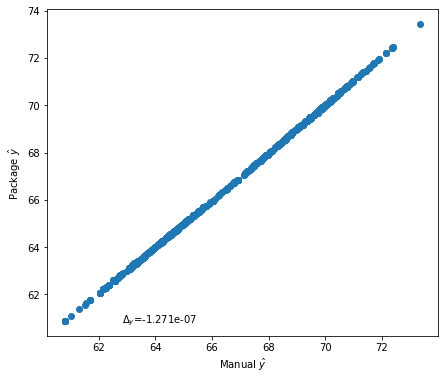

In [19]:
difference = (pred - y_hat).sum()
fig = plt.figure(figsize=(7,6))
plt.scatter(y_hat, pred)
plt.xlabel(r'Manual $\hat{y}$')
plt.ylabel(r'Package $\hat{y}$')
plt.text(y_hat.min()+2, y_hat.min(),f'$\Delta_y$={difference:.3e}');

### Examine the run-sequence plot:


In [20]:
#First we need to sort the data by one of x variables. I'm going to sort by Father
sort = np.argsort(x[:,2])

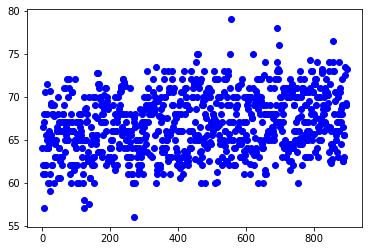

In [21]:
plt.plot(y[sort], 'bo')

In [22]:
import plotly.express as px

fig = px.scatter_3d(data,x='Father',y='Mother',z='Height',hover_name='Kids',size=y_hat, color='Gender', width=800,height=500)
fig.show()

In [23]:
fig2 = px.box(data, x=['Father','Mother','Height'],facet_col='Gender')
fig2.show()

List of named colors in Plotly:
aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen

In [ ]:
pd.value_counts(df.loc[test_idx].Gender)

In [ ]:
fig = px.scatter_matrix(df.loc[train_idx], dimensions=['Father','Mother','Height','Gender','Kids'], color='Gender', width=800,height=800)
fig.show()

I don't see any non-linear relationship between y and x. However, I'm going to specify multiple models to see which one produces best results:  
1. $H = \beta_0 + \beta_1.F + \beta_2.M \pm \beta_3.G \pm \beta_4.K$
2. $H = \beta_0 + \beta_1.F + \beta_2.M + \beta_3.(G.F.M) \pm \beta_4.K$

In [ ]:
formuals =['Height~Father+Mother+C(Gender)+Kids','Height~Father+Mother+C(Gender)*Father*Mother+Kids','Height~np.log(Father)+Mother+C(Gender)']
for f in formuals:
    res = smf.ols(formula=f, data=df.loc[train_idx]).fit()
    print("Training Adj.R^2", res.rsquared_adj)
    print("Test Adj.R^2", r2_score(df.loc[test_idx].Height,res.predict(df.loc[test_idx])), '\n')

In [ ]:
df['split'] = np.where(df.index.isin(train_idx), 'train','test')
res = smf.ols(formula=formuals[1], data=df.loc[train_idx]).fit()
resid = res.resid
p = res.get_prediction(df)
pred = p.summary_frame()
y_hat = pred['mean']
sort = df.Father.sort_values().index

In [ ]:
male = df.Gender=='M'

fig = px.scatter(df, x='Father',y='Height',color='Gender', symbol='split', width=800,height=500)
mLine = go.Scatter(x=df.Father.loc[sort][male], y=y_hat.loc[sort][male], mode='lines', name='Male Fit')
fLine = go.Scatter(x=df.Father.loc[sort][~male], y=y_hat.loc[sort][~male], mode='lines', name='Female Fit')
mUb = go.Scatter(x=df.Father.loc[sort][~male])
fig.add_traces([mLine, fLine])
fig.show()

In [ ]:
p = res.get_prediction(df)

In [ ]:
p.conf_int()

In [ ]:
pio.templates